# Sample registration of an image to patterns

Since thre is still an deformation among input images and its representation we look for a descriptive transformations...

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
import time
import copy
import numpy as np
import matplotlib.pylab as plt

sys.path += [os.path.abspath('.'), os.path.abspath('..')]  # Add path to root
from bpdl import data_utils as tl_data
import notebooks.notebook_utils as nb_utils

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Input images

In [2]:
# STATIC IMAGE - from atlas
img_static, img_moving = nb_utils.generate_synth_image_pair_simple()
img_static_fuzzy = tl_data.image_transform_binary2fuzzy(img_static, coef=0.2)
img_moving_fuzzy = tl_data.image_transform_binary2fuzzy(img_moving, coef=0.2)

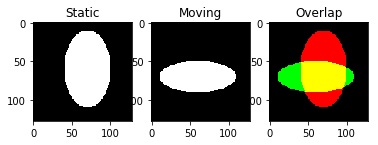

In [3]:
plt.subplot(1, 3, 1), plt.imshow(img_static, cmap=plt.cm.Greys_r), plt.title('Static')
plt.subplot(1, 3, 2), plt.imshow(img_moving, cmap=plt.cm.Greys_r), plt.title('Moving')
im_overlap = np.rollaxis(np.array([img_static, img_moving, np.zeros(img_static.shape)]), 0, 3)
_= plt.subplot(1, 3, 3), plt.imshow(im_overlap), plt.title('Overlap')

In [4]:
import SimpleITK as sitk

def warp_itk_disp_field(img, displacement_field):
    image = sitk.GetImageFromArray(img, isVector=True)
    out_transf = sitk.DisplacementFieldTransform(displacement_field)
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(out_transf)
    
    warped = resampler.Execute(image)
    return warped

def invert_disp_field(deform):
    disp_field = sitk.GetImageFromArray(deform, isVector=True)
    deform_inv = np.array(sitk.GetArrayFromImage(sitk.InverseDisplacementField(disp_field, size=disp_field.GetSize(), outputOrigin=(0.0, 0.0), outputSpacing=(1.0, 1.0))))
    disp_field_inv = sitk.GetImageFromArray(deform_inv, isVector=True)
    return disp_field_inv

## General registration via Demon

This allow using smoothing update step, see [example](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/66_Registration_Demons.html)

In [5]:
def register_itk_demons(img_static, img_moving, sigma_update=1., sigma_total=3.):
    fixed = sitk.GetImageFromArray(img_static.astype(float))
    moving = sitk.GetImageFromArray(img_moving.astype(float))
    
    regist = sitk.ImageRegistrationMethod()

    # Create initial identity transformation.
    deform = np.zeros(img_static.shape[:2] + (2,))
    disp_field = sitk.GetImageFromArray(deform.astype(float), isVector=True)
    # The image returned from the initial_transform_filter is transferred to the transform and cleared out.
    initial_transform = sitk.DisplacementFieldTransform(disp_field)
    
    # Regularization (update field - viscous, total field - elastic).
    initial_transform.SetSmoothingGaussianOnUpdate(varianceForUpdateField=sigma_update, varianceForTotalField=sigma_total) 
    
    regist.SetInitialTransform(initial_transform)
    
    #intensities are equal if the difference is less than 10HU
    regist.SetMetricAsDemons(0.001)
        
    # Multi-resolution framework.            
    # regist.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    # regist.SetSmoothingSigmasPerLevel(smoothingSigmas=[6, 4, 0]) 
    regist.SetShrinkFactorsPerLevel(shrinkFactors=[1])
    regist.SetSmoothingSigmasPerLevel(smoothingSigmas=[2])    

    regist.SetInterpolator(sitk.sitkLinear)
    regist.SetOptimizerAsGradientDescent(learningRate=1., numberOfIterations=300, 
                                         convergenceMinimumValue=1e-6, convergenceWindowSize=3)
    
    t = time.time()
    transform = regist.Execute(fixed, moving)
    print ('registration took:', time.time() - t)
    # print (regist)
        
    return transform

Register: **static <- moving** image

registration took: 2.17421293258667


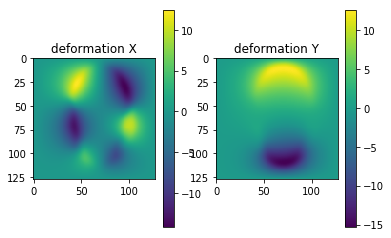

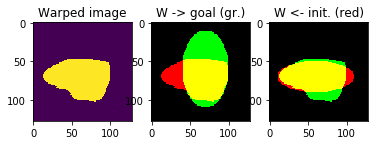

In [8]:
transform = register_itk_demons(img_static, img_moving, 1, 3)

filter = sitk.TransformToDisplacementFieldFilter()
filter.SetSize(img_static.shape[:2])
disp_field = filter.Execute(transform)
deform = np.array(sitk.GetArrayFromImage(disp_field)).copy()
nb_utils.show_registered_deformation(sitk.GetArrayFromImage(disp_field))
warped = warp_itk_disp_field(img_moving, disp_field)
nb_utils.show_registered_overlap(sitk.GetArrayViewFromImage(warped), img_static, img_moving)

Invert transformation: **static -> moving** image

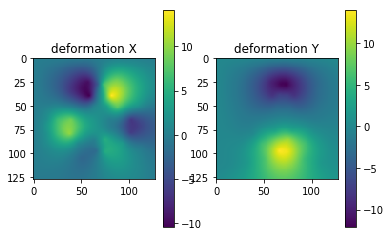

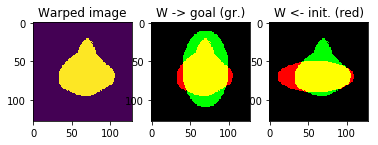

In [9]:
disp_field_inv = invert_disp_field(deform)
nb_utils.show_registered_deformation(sitk.GetArrayFromImage(disp_field_inv))
warped = warp_itk_disp_field(img_static, disp_field_inv)
nb_utils.show_registered_overlap(sitk.GetArrayViewFromImage(warped), img_static, img_moving)

Register: **static <- static FUZZY** image

registration took: 1.5904293060302734


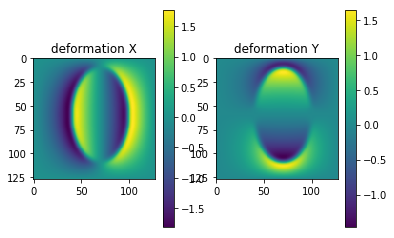

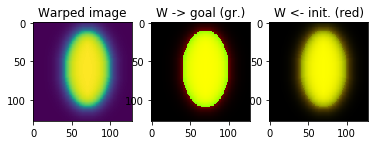

In [10]:
transform = register_itk_demons(img_static, img_static_fuzzy)

filter = sitk.TransformToDisplacementFieldFilter()
filter.SetSize(img_static.shape[:2])
disp_field = filter.Execute(transform)
deform = np.array(sitk.GetArrayFromImage(disp_field)).copy()
nb_utils.show_registered_deformation(sitk.GetArrayFromImage(disp_field))
warped = warp_itk_disp_field(img_static_fuzzy, disp_field)
nb_utils.show_registered_overlap(sitk.GetArrayViewFromImage(warped), img_static, img_static_fuzzy)

Invert transformation: **static -> static FUZZY** image

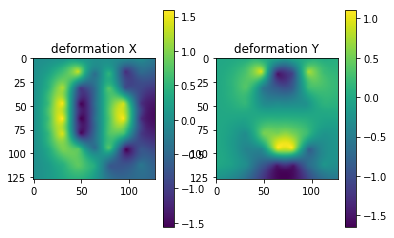

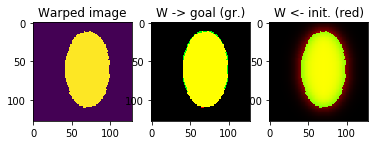

In [11]:
disp_field_inv = invert_disp_field(deform)
nb_utils.show_registered_deformation(sitk.GetArrayFromImage(disp_field_inv))
warped = warp_itk_disp_field(img_static, disp_field_inv)
nb_utils.show_registered_overlap(sitk.GetArrayViewFromImage(warped), img_static, img_static_fuzzy)

Register: **static <- moving FUZZY** image

registration took: 1.9389243125915527


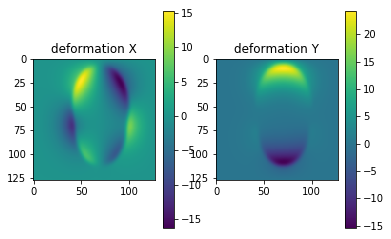

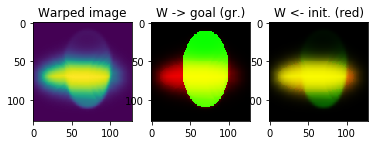

In [12]:
transform = register_itk_demons(img_static, img_moving_fuzzy, 0.5, 1.)

filter = sitk.TransformToDisplacementFieldFilter()
filter.SetSize(img_static.shape[:2])
disp_field = filter.Execute(transform)
deform = np.array(sitk.GetArrayFromImage(disp_field)).copy()
nb_utils.show_registered_deformation(sitk.GetArrayFromImage(disp_field))
warped = warp_itk_disp_field(img_moving_fuzzy, disp_field)
nb_utils.show_registered_overlap(sitk.GetArrayViewFromImage(warped), img_static, img_moving_fuzzy)

Invert transformation: **static -> moving FUZZY** image

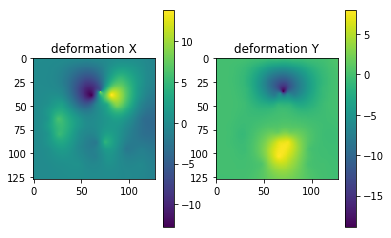

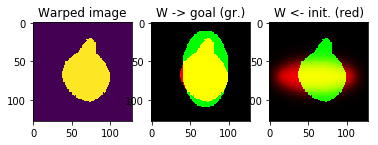

In [13]:
disp_field_inv = invert_disp_field(deform)
nb_utils.show_registered_deformation(sitk.GetArrayFromImage(disp_field_inv))
warped = warp_itk_disp_field(img_static, disp_field_inv)
nb_utils.show_registered_overlap(sitk.GetArrayViewFromImage(warped), img_static, img_moving_fuzzy)

## Demons: classic

This [example](http://simpleitk.readthedocs.io/en/master/Examples/DemonsRegistration1/Documentation.html) illustrates how to use the classic Demons registration algorithm. The user supplied parameters for the algorithm are the number of iterations and the standard deviations for the Gaussian smoothing of the total displacement field. Additional methods which control regularization, total field smoothing for elastic model or update field smoothing for viscous model are available.

In [16]:
def register_itk_demon_diffe(img_static, img_moving, sigma_update=1.5):
    fixed = sitk.GetImageFromArray(img_static)
    moving = sitk.GetImageFromArray(img_moving)
    
    # matcher = sitk.HistogramMatchingImageFilter()
    # matcher.SetNumberOfHistogramLevels(128)
    # matcher.SetNumberOfMatchPoints(7)
    # matcher.ThresholdAtMeanIntensityOn()
    # moving = matcher.Execute(moving, fixed)
    
    demons = sitk.DiffeomorphicDemonsRegistrationFilter()
    demons.SetNumberOfIterations(500)
    demons.SetSmoothDisplacementField(True)
    demons.SetStandardDeviations(1.0)
    demons.SetSmoothUpdateField(True)
    demons.SetUpdateFieldStandardDeviations(sigma_update)
    
    t = time.time()
    displacement_field = demons.Execute(fixed, moving)
    print ('demons took:', time.time() - t)
    return displacement_field

Register: **static <- moving** image

demons took: 2.1147267818450928


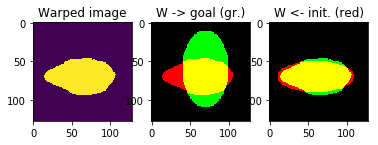

In [17]:
disp_field = register_itk_demon_diffe(img_static, img_moving, 1.)
warped = warp_itk_disp_field(img_moving, disp_field)
nb_utils.show_registered_overlap(sitk.GetArrayViewFromImage(warped), img_static, img_moving)

Register: **static <- static FUZZY** image

demons took: 2.1867618560791016


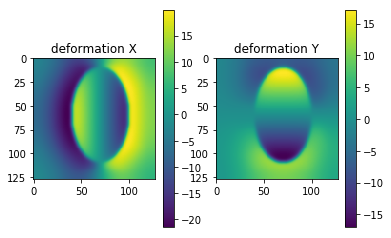

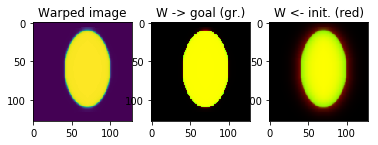

In [18]:
disp_field = register_itk_demon_diffe(img_static.astype(float), img_static_fuzzy)
nb_utils.show_registered_deformation(sitk.GetArrayFromImage(disp_field))
warped = warp_itk_disp_field(img_static_fuzzy, disp_field)
nb_utils.show_registered_overlap(sitk.GetArrayViewFromImage(warped), img_static, img_static_fuzzy)

Register: **static <- moving FUZZY** image

demons took: 2.2650246620178223


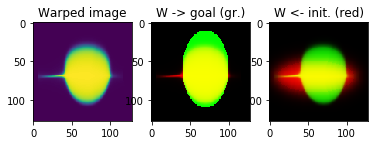

In [19]:
disp_field = register_itk_demon_diffe(img_static.astype(float), img_moving_fuzzy)
warped = warp_itk_disp_field(img_moving_fuzzy, disp_field)
nb_utils.show_registered_overlap(sitk.GetArrayViewFromImage(warped), img_static, img_moving_fuzzy)

## Demons: fast symmetric forces

This [example](http://simpleitk.readthedocs.io/en/master/Examples/DemonsRegistration2/Documentation.html) illustrates how to use the fast symmetric forces Demons algorithm. As the name implies, unlike the classical algorithm, the forces are symmetric.

In [21]:
def regsiter_itk_demon_fast(img_static, img_moving, sigma_update=2.0):
    fixed = sitk.GetImageFromArray(img_static)
    moving = sitk.GetImageFromArray(img_moving)
    
    # matcher = sitk.HistogramMatchingImageFilter()
    # matcher.SetNumberOfHistogramLevels(128)
    # matcher.SetNumberOfMatchPoints(7)
    # matcher.ThresholdAtMeanIntensityOn()
    # moving = matcher.Execute(moving, fixed)
    
    demons = sitk.FastSymmetricForcesDemonsRegistrationFilter()
    demons.SetMaximumUpdateStepLength(1)
    demons.SetNumberOfIterations(150)
    demons.SetSmoothDisplacementField(True)
    demons.SetStandardDeviations(1.0)
    demons.SetSmoothUpdateField(True)
    demons.SetUpdateFieldStandardDeviations(sigma_update)
    
    t = time.time()
    displacement_field = demons.Execute(fixed, moving)
    print ('demons took:', time.time() - t)
    return displacement_field

Register: **static <- moving** image

demons took: 0.45868420600891113


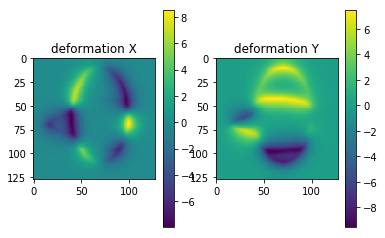

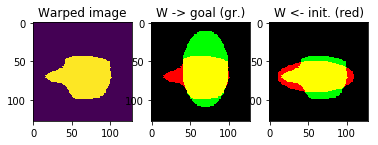

In [23]:
disp_field = regsiter_itk_demon_fast(img_static, img_moving, 1.)
nb_utils.show_registered_deformation(sitk.GetArrayFromImage(disp_field))
warped = warp_itk_disp_field(img_moving, disp_field)
nb_utils.show_registered_overlap(sitk.GetArrayViewFromImage(warped), img_static, img_moving)

Register: **static <- static FUZZY** image

demons took: 0.4698212146759033


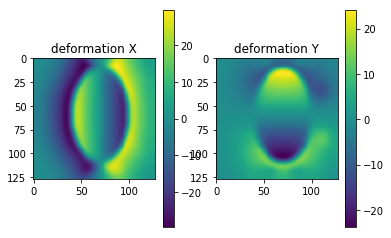

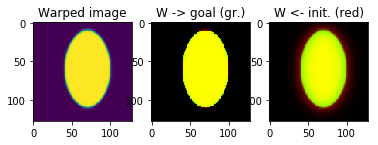

In [24]:
disp_field = regsiter_itk_demon_fast(img_static.astype(float), img_static_fuzzy)
deform = np.array(sitk.GetArrayFromImage(disp_field))
nb_utils.show_registered_deformation(sitk.GetArrayFromImage(disp_field))
warped = warp_itk_disp_field(img_static_fuzzy, disp_field)
nb_utils.show_registered_overlap(sitk.GetArrayViewFromImage(warped), img_static, img_static_fuzzy)

Register: **static <- moving FUZZY** image

demons took: 0.59214186668396


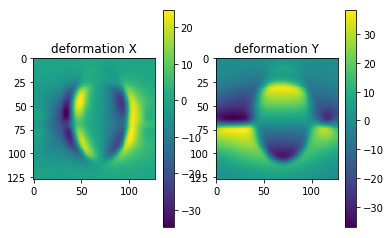

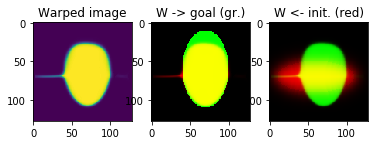

In [25]:
disp_field = regsiter_itk_demon_fast(img_static.astype(float), img_moving_fuzzy)
nb_utils.show_registered_deformation(sitk.GetArrayFromImage(disp_field))
warped = warp_itk_disp_field(img_moving_fuzzy, disp_field)
nb_utils.show_registered_overlap(sitk.GetArrayViewFromImage(warped), img_static, img_moving_fuzzy)

# Test transf. invertability

demons took: 1.8837628364562988
(128, 128, 2)


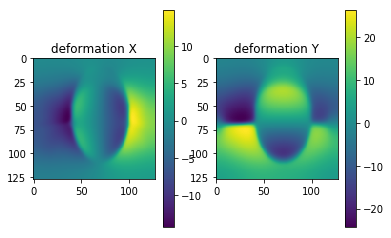

In [27]:
from scipy import interpolate
disp_field = register_itk_demon_diffe(img_static.astype(float), img_moving_fuzzy)

deform = np.array(sitk.GetArrayFromImage(disp_field))
print (deform.shape)
nb_utils.show_registered_deformation(deform)

Compare two different ways of invertig image transformation via displacement field...

(128, 128, 2)
(128, 128, 2)


['AddTransform', 'GetDimension', 'GetDisplacementField', 'GetFixedParameters', 'GetITKBase', 'GetInverse', 'GetInverseDisplacementField', 'GetName', 'GetParameters', 'IsLinear', 'MakeUnique', 'SetDisplacementField', 'SetFixedParameters', 'SetIdentity', 'SetInterpolator', 'SetInverse', 'SetInverseDisplacementField', 'SetParameters', 'SetSmoothingBSplineOnUpdate', 'SetSmoothingGaussianOnUpdate', 'SetSmoothingOff', 'TransformPoint', 'WriteTransform', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__swig_destroy__', '__swig_getmethods__', '__swig_setmethods__', '__weakref__', '_s', 'this']

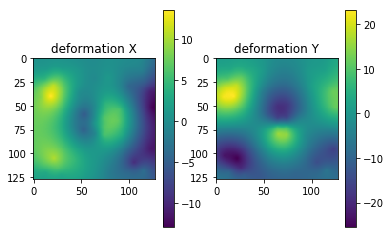

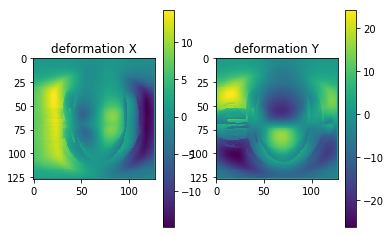

In [28]:
deform_inv = np.array(sitk.GetArrayFromImage(sitk.InverseDisplacementField(disp_field, size=disp_field.GetSize(), outputOrigin=(0.0, 0.0), outputSpacing=(1.0, 1.0))))
print (deform_inv.shape)
nb_utils.show_registered_deformation(deform_inv)

filter = sitk.InvertDisplacementFieldImageFilter()
filter.EnforceBoundaryConditionOn()
deform_inv = np.array(sitk.GetArrayFromImage(filter.Execute(disp_field)))
print (deform_inv.shape)
nb_utils.show_registered_deformation(deform_inv)

# out_transf = sitk.DisplacementFieldTransform(disp_field)
out_transf = sitk.DisplacementFieldTransform(sitk.InverseDisplacementField(disp_field, size=disp_field.GetSize(), outputOrigin=(0.0, 0.0), outputSpacing=(1.0, 1.0)))
print (dir(out_transf))

# print (sitk.GetArrayFromImage(out_transf.GetDisplacementField()).shape)
# nb_utils.show_registered_deformation(sitk.GetArrayFromImage(out_transf.GetDisplacementField()))